<a href="https://colab.research.google.com/github/FernandaSzAdr/Redes-Neurais--UFRPE-2019.1/blob/master/SOM%20-%20Self%20Organising%20Map/codigos/Self_Organising_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!git clone https://github.com/FernandaSzAdr/Redes-Neurais--UFRPE-2019.1.git

Cloning into 'Redes-Neurais--UFRPE-2019.1'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 67 (delta 10), reused 20 (delta 1), pack-reused 0
Unpacking objects: 100% (67/67), done.


# Self-Organising Maps Netowork

Segue um código exemplo da rede neural SOM

Para maiores detalhes ver site:
http://blog.yhat.com/posts/self-organizing-maps-2.html

In [0]:
from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

### Configuração da SOM

Escolhe:
1. Tamanho do mapa da SOM: X e Y
2. Número de iterações
3. Taxa de aprendizado
4. Tipo de normalização dos dados


In [0]:
X = 5
Y = 5
network_dimensions = np.array([X, Y])
n_iterations = 10000
init_learning_rate = 0.1

normalise_data = True

# if True, assume all data on common scale
# if False, normalise to [0 1] range along each column
normalise_by_column = False

### Cria base com dados aleatórios em 3 classes

In [0]:
# 8 colours as initial test set
#raw_data = np.array([[1, 0, 0], [0, 1, 0],
#                     [0, 0.5, 0.25], [0, 0, 1],
#                     [0, 0, 0.5], [1, 1, 0.2],
#                     [1, 0.4, 0.25], [1, 0, 1]]).T * 255
# or use random colours
raw_data = np.random.randint(0, 255, (3, 100))

# establish variables based on data
m = raw_data.shape[0]
n = raw_data.shape[1]

data = raw_data
# check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = raw_data.max(axis=0)
        data = raw_data / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data = raw_data / data.max()


In [0]:
#cria raio inicial de acordo com o tamanho inicial do mapa da SOM
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

# weight matrix needs to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))



### Rede Neural SOM

In [0]:
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max    
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

In [0]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

In [0]:
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

In [0]:
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

### Aprendizado SOM

In [0]:
for i in range(n_iterations):
    #print('Iteration %d' % i)
    
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, 3)

### Visualiza o mapa criado

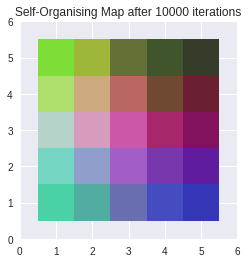

In [11]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()

#EXEMPLO COM BIBLIOTECA SOMCLU

Essa biblioteca suporta uso de GPUs e possui implementação super simples

In [1]:
!pip install somoclu
# !pip install ipython ipdb

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import somoclu
# import ipdb?
%matplotlib inline


## Exemplo com a base de dados Iris

In [0]:
local = 'Redes-Neurais--UFRPE-2019.1/SOM - Self Organising Map/codigos/iris.csv'

/usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/art3d.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/art3d.py:735: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


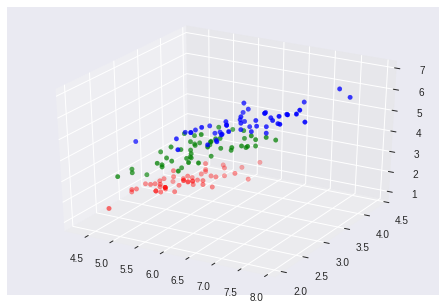

In [22]:
c1 = np.genfromtxt(local, delimiter=',', usecols=(0, 1, 2, 3), max_rows = 50) 
c2 = np.genfromtxt(local, delimiter=',', usecols=(0, 1, 2, 3),skip_header = 50, max_rows = 50)
c3 = np.genfromtxt(local, delimiter=',', usecols=(0, 1, 2, 3),skip_header=100, max_rows = 50)
data = np.float32(np.concatenate((c1, c2, c3)))
 
colors = ["red"] * 50
colors.extend(["green"] * 50)
colors.extend(["blue"] * 50)
#colors.extend(["yellow"] * 50)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:, 0], data[:, 1], data[:, 2], data[:, 3], c=colors)
labels = range(150)

### Executando a rede neural SOM

In [15]:
#escolha o tamanho da rede SOM
n_rows, n_columns = 100, 160
som = somoclu.Somoclu(n_columns, n_rows, data=data)
%time som.train()

CPU times: user 13 s, sys: 9.78 ms, total: 13 s
Wall time: 6.52 s


### Visualizar o resultado:

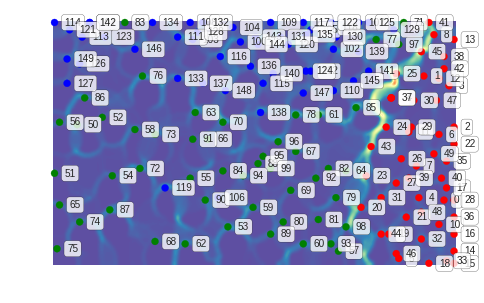

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [16]:
som.view_umatrix(bestmatches=True, bestmatchcolors=colors, labels=labels)

#Mini-Projeto 2:

Execute uma das Redes Neurais SOM acima com a base de dados MNist que possui caracteres de 0 a 9. Mostre os resultados abaixo:

1. Mostre 3 configurações de Mapa diferentes
2. Construa a matriz de confusão mostrando o resultado desses mapas (Se tem dúvidas, olhe a aula de Avaliação de resultados da disciplina anterior de Inteligência Artificial)
3. Calcule a taxa de acerto utilizando a matriz de confusão gerada no passo anterior.

DATA DE ENTREGA: 09/02/2019




### Carregando MNist database

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
import random as ran
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def train_size(num):
  x_train = mnist.train.images[:num,:]
  y_train = mnist.train.labels[:num,:]
  return x_train, y_train

In [0]:
def display_digit(num):
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

In [7]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

x_train, y_train = train_size(100)
x_test, y_test = train_size(110)
x_test = x_test[100:110,:]; y_test = y_test[100:110,:]

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

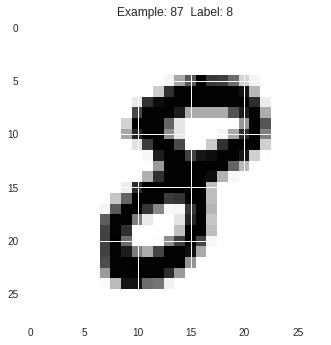

In [8]:
display_digit(ran.randint(0, x_train.shape[0]))

## Utilizando SOMCLU

In [0]:
!pip install somoclu

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import somoclu
%matplotlib inline


### Organinzando database

In [0]:
data_mnist = x_train
data = []

for i in range(len(data_mnist)):
  data.append(data_mnist[i].flatten())

data = np.float32(data)
labels = range(len(data))

### Executando a rede neural SOM

In [46]:
#escolha o tamanho da rede SOM
n_rows, n_columns = 20, 20
som = somoclu.Somoclu(n_columns, n_rows, kerneltype=1, verbose=2,
                      gridtype='rectangular', neighborhood='gaussian')
# som = somoclu.Somoclu(n_columns, n_rows, kerneltype=1, verbose=1,
#                       neighborhood='bubble', gridtype='rectangular')
%time som.train(data)

CPU times: user 3.02 s, sys: 131 ms, total: 3.15 s
Wall time: 3.16 s


### Visualizar o resultado:

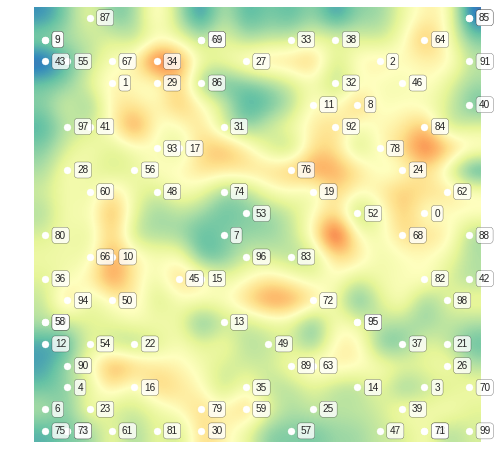

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [47]:
som.view_umatrix(bestmatches=True, labels=labels)

## Utilizando SOM Lattice


[Implementação](https://wonikjang.github.io/deeplearning_unsupervised_som/2017/06/30/som.html)

[Rede SOM](https://codesachin.wordpress.com/2015/11/28/self-organizing-maps-with-googles-tensorflow/)

### Rede SOM

In [0]:
!pip install --force-reinstall tensorflow

In [0]:
import tensorflow as tf
import numpy as np

In [0]:
class SOM(object):

    # To check if the SOM has been trained
    trained = False

    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):

        # Assign required variables first
        self.m = m; self.n = n
        if alpha is None:
            alpha = 0.2
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self.n_iterations = abs(int(n_iterations))

        self.graph = tf.Graph()

        with self.graph.as_default():

            # To save data, create weight vectors and their location vectors

            self.weightage_vects = tf.Variable(tf.random_normal( [m * n, dim]) )

            self.location_vects = tf.constant(np.array(list(self.neuron_locations(m, n))))

            # Training inputs

            # The training vector
            self.vect_input = tf.placeholder("float", [dim])
            # Iteration number
            self.iter_input = tf.placeholder("float")

            # Training Operation  # tf.pack result will be [ (m*n),  dim ]

            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(tf.pow(
                tf.subtract(self.weightage_vects,
                       tf.stack([self.vect_input for _ in range(m * n)])), 2), 1)), 0) 
                    

            slice_input = tf.pad(tf.reshape(bmu_index, [1]), np.array([[0, 1]]))
            bmu_loc = tf.reshape(tf.slice(self.location_vects, slice_input, 
                        tf.constant(np.array([1, 2]), dtype=tf.int64) ), [2])

            # To compute the alpha and sigma values based on iteration number
            learning_rate_op = tf.subtract(1.0, tf.div(self.iter_input, self.n_iterations))
            alpha_op = tf.multiply(alpha, learning_rate_op)
            sigma_op = tf.multiply(sigma, learning_rate_op)

            # learning rates for all neurons, based on iteration number and location w.r.t. BMU.
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                self.location_vects, tf.stack( [bmu_loc for _ in range(m * n)] ) ) , 2 ), 1)

            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(
                bmu_distance_squares, "float32"), tf.pow(sigma_op, 2))))
            learning_rate_op = tf.multiply(alpha_op, neighbourhood_func)

            # Finally, the op that will use learning_rate_op to update the weightage vectors of all neurons
            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim]) for i in range(m * n)] )

            ### Strucutre of updating weight ###
            ### W(t+1) = W(t) + W_delta ###
            ### wherer, W_delta = L(t) * ( V(t)-W(t) ) ###

            # W_delta = L(t) * ( V(t)-W(t) )
            weightage_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(tf.stack([self.vect_input for _ in range(m * n)]), self.weightage_vects))

            # W(t+1) = W(t) + W_delta
            new_weightages_op = tf.add(self.weightage_vects, weightage_delta)

            # Update weightge_vects by assigning new_weightages_op to it.
            self.training_op = tf.assign(self.weightage_vects, new_weightages_op)

            self.sess = tf.Session()
            init_op = tf.global_variables_initializer()
            self.sess.run(init_op)

    def neuron_locations(self, m, n):

        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def train(self, input_vects):

        # Training iterations
        for iter_no in range(self.n_iterations):
            # Train with each vector one by one
            for input_vect in input_vects:
                self.sess.run(self.training_op, 
                        feed_dict={self.vect_input: input_vect, self.iter_input: iter_no})

        # Store a centroid grid for easy retrieval later on
        centroid_grid = [[] for i in range(self.m)]
        self.weightages = list(self.sess.run(self.weightage_vects))
        self.locations = list(self.sess.run(self.location_vects))
        for i, loc in enumerate(self.locations):
            centroid_grid[loc[0]].append(self.weightages[i])

        self.centroid_grid = centroid_grid

        self.trained = True

    def get_centroids(self):

        if not self.trained:
            raise ValueError("SOM not trained yet")
        return self.centroid_grid

    def map_vects(self, input_vects):

        if not self.trained:
            raise ValueError("SOM not trained yet")

        to_return = []
        for vect in input_vects:
            min_index = min( [i for i in range(len(self.weightages))], 
                            key=lambda x: np.linalg.norm(vect - self.weightages[x]) )
            to_return.append(self.locations[min_index])

        return to_return

### Configurando rede

In [0]:
som = SOM(30, 30, x_train.shape[1], 200)
som.train(x_train)

### Rodando com Treino

In [0]:
mapped = som.map_vects(x_train)
mappedarr = np.array(mapped)
x1 = mappedarr[:,0]; y1 = mappedarr[:,1]

index = [ np.where(r==1)[0][0] for r in y_train ]
index = list(map(str, index))


Text(0.5, 1.0, 'Train MNIST 100')

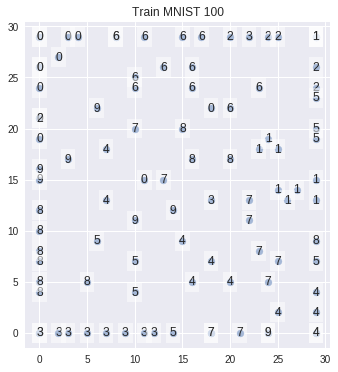

In [22]:
plt.figure(1, figsize=(12,6))
plt.subplot(121)
# Plot 1 for Training only
plt.scatter(x1,y1)
# Just adding text
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.title('Train MNIST 100')

### Rodando com Teste + Treino

In [0]:
mappedtest = som.map_vects(x_test)
mappedtestarr = np.array(mappedtest)
x2 = mappedtestarr[:,0]
y2 = mappedtestarr[:,1]

index2 = [ np.where(r==1)[0][0] for r in y_test ]
index2 = list(map(str, index2))

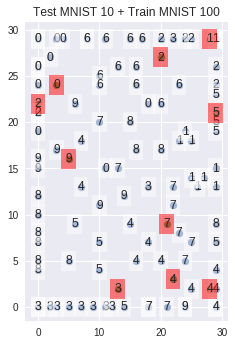

In [24]:
plt.subplot(122)
# Plot 2: Training + Testing
plt.scatter(x1,y1)
# Just adding text
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

plt.scatter(x2,y2)
# Just adding text
for i, m in enumerate(mappedtest):
    plt.text( m[0], m[1],index2[i], ha='center', va='center', bbox=dict(facecolor='red', alpha=0.5, lw=0))
plt.title('Test MNIST 10 + Train MNIST 100')

plt.show()